# 1. Fooling neural networks
"Fooling" neural networks refers to the concept of generating inputs that cause a neural network to make incorrect predictions or to behave unexpectedly, often with high confidence. This phenomenon is primarily associated with adversarial examples, which are specially crafted inputs designed to deceive neural networks.

## 1.1. Understanding Adversarial Examples
Adversarial examples exploit the way neural networks learn and process inputs. Despite their high performance on standard datasets, neural networks can be surprisingly sensitive to small perturbations or modifications to their inputs. These perturbations, although often imperceptible to humans, can lead the network to misclassify inputs with high confidence.

## 1.2. How Adversarial Examples are Generated
The basic idea behind generating adversarial examples is to apply a small but intentionally worst-case perturbation to an example from the dataset that causes the neural network to mislabel the example. This perturbation is often calculated using gradients of the neural network's loss function with respect to the input image, which indicates how to change the input to increase the loss. 

## 1.3. Implications
Understanding and defending against adversarial examples is a major area of research in deep learning security. Researchers develop more robust models and explore techniques like adversarial training (training with adversarial examples), defensive distillation, and feature squeezing to mitigate these vulnerabilities.

Here we show how to fool a neural network using a gradient ascent technique over the input.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras import backend as K
from tensorflow.keras import losses 
import numpy as np
import matplotlib.pyplot as plt

2024-05-16 06:37:58.432244: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 06:37:58.432378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 06:37:58.590516: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 2. VGG16 Model
The VGG16 model is a significant milestone in the field of deep learning, especially for image recognition tasks. Developed by Karen Simonyan and Andrew Zisserman from the Visual Graphics Group at Oxford (hence "VGG"), it was introduced in 2014 in their paper "`Very Deep Convolutional Networks for Large-Scale Image Recognition`." VGG16 was a runner-up in the 2014 ILSVRC (ImageNet Large Scale Visual Recognition Challenge), which is a benchmark in image classification and recognition.

## 2.1. Architecture
VGG16 is known for its simplicity and depth. It uses a series of convolutional layers with small receptive fields (3x3 kernels), followed by max-pooling layers, several fully connected layers, and a final softmax classification layer. 
- **Input Layer:** Takes an image of fixed size 224x224 pixels as input.
- **Convolutional Layers:** Contains 13 convolutional layers. The convolution stride is fixed at 1 pixel; the spatial padding of convolution layer input is such that the spatial resolution is preserved after convolution, i.e., padding of 1 pixel for 3x3 convolutions.
- **Activation Function:** Uses the ReLU (Rectified Linear Unit) activation function throughout the network.
- **Pooling Layers:** Five max-pooling layers follow some of the convolutional layers. These are performed over a 2x2 pixel window, with stride 2.
- **Fully Connected Layers:** Three fully connected layers follow the last max-pooling layer. The first two have 4096 channels each, the third performs 1000-way ILSVRC classification and thus contains 1000 channels (one for each class).
- **Output Layer:** The final layer is a softmax layer that outputs probabilities of the 1000 classes.

## 2.2. Features

1. **Depth:** The depth of the network, with its 16 weight layers, was instrumental in learning rich feature hierarchies. Before VGG16, most networks were significantly shallower.
2. **Uniform Architecture:** The use of only 3x3 convolutions, but many more layers than previous architectures, allowed for more complex patterns to be learned at higher abstract levels.
3. **Transfer Learning:** The VGG16 model, trained on a dataset as large as ImageNet, proved to be an excellent feature extractor for various other tasks beyond simple classification. Its features can be repurposed for other vision tasks like object detection and image segmentation by modifying and training just the later layers while keeping earlier layers frozen.

## 2.3. Performance and Limitations
While VGG16 was state-of-the-art in 2014, it is considered too computationally intensive and slow for many modern applications, primarily due to its depth and the large number of parameters (138 million). More recent architectures like `ResNet`, which introduced residual connections, and Google’s Inception networks, offer similar or improved performance with reduced computational overhead. Nonetheless, VGG16 remains a valuable study tool and baseline for the design of deeper architectures in computer vision.

In [2]:
model = VGG16(weights='imagenet', include_top=True)
model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Next, we will get an image from input and then, classify it. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
label = 94
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Predicted: [('n01833805', 'hummingbird', 0.42147717), ('n01443537', 'goldfish', 0.19440392), ('n03476684', 'hair_slide', 0.09284151)]


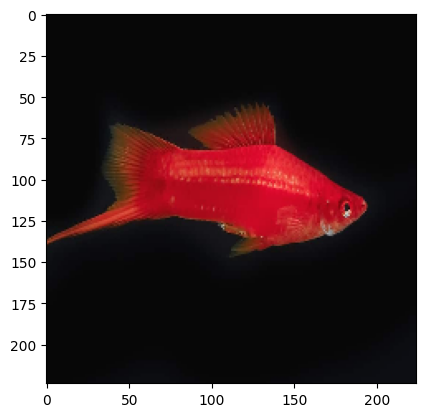

In [3]:
img = image.load_img('/kaggle/input/image1/fish/red_fish5.jpeg', target_size=(224, 224))

x0 = image.img_to_array(img)
x = np.expand_dims(x0, axis=0)  # Adding Batch Dimension
preds = model.predict(x)

print("label = {}".format(np.argmax(preds)))
print('Predicted:', decode_predictions(preds, top=3)[0])

xd = image.array_to_img(x[0])
imageplot = plt.imshow(xd)
plt.show()

# 3. Gradient Ascent
Gradient ascent is an optimization technique used to maximize a function, which is essentially the opposite of gradient descent, the latter being more commonly used in machine learning to minimize a function. In neural networks, gradient ascent is used in scenarios where the goal is to increase a certain objective function.

## 3.1. Basic Concept
In gradient ascent, the parameters (or variables) of a function are adjusted by adding a scaled gradient rather than subtracting it (which is done in gradient descent). The gradient, in this context, represents the direction of the steepest increase in the function's value. By iteratively moving in the direction of this gradient, the function's output is maximized.

## 3.2. Mathematical Formulation
Given a differentiable function $ f(\mathbf{x}) $, where $ \mathbf{x} $ is a vector of parameters or inputs, the update rule in gradient ascent is:

$$ \mathbf{x}_{\text{next}} = \mathbf{x}_{\text{current}} + \eta \nabla f(\mathbf{x}_{\text{current}}) $$

Here:
- $ \mathbf{x}_{\text{current}} $ represents the current parameter values.
- $ \nabla f(\mathbf{x}_{\text{current}}) $ is the gradient of the function at $ \mathbf{x}_{\text{current}} $, pointing in the direction of the greatest increase of $ f $.
- $ \eta $ (eta) is the learning rate, a positive scalar determining the size of the step to take on each iteration.

## 3.3. Applications in Deep Learning

1. **Adversarial Examples**: Used to create input data that maximally confuses a trained model, by maximizing the model's error or maximizing the output in favor of an incorrect class.
2. **Feature Visualization**: Helps in visualizing what activates certain neurons or layers in a neural network by maximizing the activation of these neurons when a particular input is fed into the network.
3. **Neural Style Transfer**: In style transfer, the goal might be to maximize the similarity between the generated image and the style features of one image combined with the content features of another.

Now we try to convert the image into something different: a tiger shark, with label 3.

In [4]:
output_index = 3  # tiger shark

expected_output = np.zeros(1000)
expected_output[output_index] = 1
expected_output = K.variable(np.reshape(expected_output,(1,1000)))


Now we simply iterate the gradient ascent technique for a sufficent number of steps, working on a copy of the original image

In [5]:
input_img_data = np.copy(x)

# run gradient ascent for 50 steps
for i in range(50):
    print("Iteration n. {}".format(i))
    
    with tf.GradientTape() as g:
      x = K.variable(input_img_data)
      y = model(x)
      loss = tf.keras.losses.categorical_crossentropy(y, expected_output)
    
    res = y[0]
    print("Fish prediction: {}".format(res[386]))
    print("Tiger shark prediction: {}".format(res[3]))
    
    grads_value = g.gradient(loss, x)[0]
    print(grads_value.shape, "\n")
    
    ming = np.min(grads_value)
    maxg = np.max(grads_value)
    #print("min grad = {}".format(ming))
    #print("max grad = {}".format(maxg))
    scale = 1/(maxg -ming)
    
    #brings gradients to a sensible value
    input_img_data -= grads_value * scale


Iteration n. 0
Fish prediction: 2.8964603870917927e-07
Tiger shark prediction: 0.00022069568512961268
(224, 224, 3) 

Iteration n. 1
Fish prediction: 5.263405569166935e-07
Tiger shark prediction: 0.0006098788580857217
(224, 224, 3) 

Iteration n. 2
Fish prediction: 7.94131551629107e-07
Tiger shark prediction: 0.001714638201519847
(224, 224, 3) 

Iteration n. 3
Fish prediction: 1.2598628700288828e-06
Tiger shark prediction: 0.004426790401339531
(224, 224, 3) 

Iteration n. 4
Fish prediction: 1.4595296988773043e-06
Tiger shark prediction: 0.00999055989086628
(224, 224, 3) 

Iteration n. 5
Fish prediction: 1.751562990648381e-06
Tiger shark prediction: 0.01971478760242462
(224, 224, 3) 

Iteration n. 6
Fish prediction: 1.6541446257178904e-06
Tiger shark prediction: 0.040464144200086594
(224, 224, 3) 

Iteration n. 7
Fish prediction: 2.2558410819328856e-06
Tiger shark prediction: 0.07568822801113129
(224, 224, 3) 

Iteration n. 8
Fish prediction: 1.910204446176067e-06
Tiger shark prediction

At the end, `VGG16` is extremely confident he is looking at a tiger shark

In [6]:
preds = model.predict(input_img_data)
print("label = {}".format(np.argmax(preds)))
print('Predicted:', decode_predictions(preds, top=3)[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
label = 3
Predicted: [('n01491361', 'tiger_shark', 0.9999138), ('n01484850', 'great_white_shark', 3.9593826e-05), ('n01494475', 'hammerhead', 2.0598523e-05)]


Let us look at the resulting image (we both print the original and the processed image)

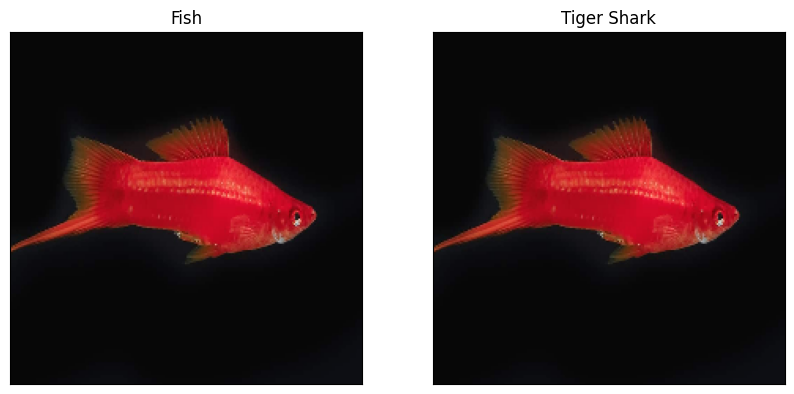

In [7]:
nimg = input_img_data[0]
nimg = image.array_to_img(img)

plt.figure(figsize=(10,5))

ax = plt.subplot(1, 2, 1)
plt.title("Fish")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.imshow(xd)

ax = plt.subplot(1, 2, 2)
plt.title("Tiger Shark")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.imshow(nimg)

imageplot = plt.imshow(img)
plt.show()

What a fool Network :)